### Pre&Post Survey Correlation Evaluation:

- BigFive.csv
- FlourishingScale.csv
- LonelinessScale.csv
- panas.csv

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [95]:
big5_df = pd.read_csv('../dataset/survey/BigFive.csv')


In [96]:
def convert2int(big5_mod):
    for column in big5_mod:
        
        if big5_mod[column].dtypes =='float64':
            try:
                big5_mod[column] = big5_mod[column].astype('int64')
            except:
                print(column,big5_mod[column].dtypes)
    return big5_mod

In [97]:
# clean
big5_mod = big5_df
big5_mod = big5_mod.replace('Disagree Strongly',1)
big5_mod = big5_mod.replace('Disagree a little',2)
big5_mod = big5_mod.replace('Neither agree nor disagree',3)
big5_mod = big5_mod.replace('Agree a little',4)
big5_mod = big5_mod.replace('Agree strongly',5)
big5_mod = big5_mod.dropna()

# make the data easy read for machine and clean the type of the columns
old_col = big5_mod.columns
big5_mod = big5_mod.rename({old_col[i]:'Q'+str(i-1) for i in range(2,len(old_col))},axis='columns' )
big5_mod = convert2int(big5_mod)

In [98]:
# reverse the score the reversed question
big5_mod_reverse = big5_mod
reverse = [2,6,8,9,12,18,21,23,24,27,31,34,35,37,41,43]
swap = {1:5,2:4,3:3,4:2,5:1}
for i in reverse:
    big5_mod_reverse['Q'+str(i)] = [swap[score] for score in big5_mod_reverse['Q'+str(i)]]
    big5_mod_reverse = big5_mod_reverse.rename({'Q'+str(i):'Q'+str(i)+'R'},axis='columns')
    


In [99]:
big5 = {'Extraversion':['1', '6R', '11', '16', '21R', '26', '31R', '36'],
       'Agreeableness': ['2R', '7', '12R', '17', '22', '27R', '32', '37R', '42'],
       'Conscientiousness': ['3', '8R', '13', '18R', '23R', '28', '33', '38', '43R'],
        'Neuroticism': ['4', '9R', '14', '19', '24R', '29', '34R', '39'],
        'Openness': ['5', '10', '15', '20', '25', '30', '35R', '40', '41R', '44']}
for index,user in big5_mod_reverse.iterrows():
    big5_mod_reverse.at[index,'Extraversion'] = sum([int(user['Q'+col]) for col in big5['Extraversion']])
    big5_mod_reverse.at[index,'Agreeableness'] = sum([int(user['Q'+col]) for col in big5['Agreeableness']])
    big5_mod_reverse.at[index,'Conscientiousness'] = sum([int(user['Q'+col]) for col in big5['Conscientiousness']])
    big5_mod_reverse.at[index,'Neuroticism'] = sum([int(user['Q'+col]) for col in big5['Neuroticism']])
    big5_mod_reverse.at[index,'Openness'] = sum([int(user['Q'+col]) for col in big5['Openness']])
big5_mod_reverse = convert2int(big5_mod_reverse)

In [100]:
print(len(big5_mod_reverse))
big5_mod_reverse.head()

77


,uid,type,Q1,Q2R,Q3,Q4,Q5,Q6R,Q7,Q8R,...,Q40,Q41R,Q42,Q43R,Q44,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
0,u00,pre,4,3,3,3,5,2,3,2,...,4,4,4,2,4,30,26,27,25,45
1,u01,pre,3,2,5,5,4,2,5,4,...,5,4,3,4,4,25,34,40,22,39
2,u02,pre,2,2,5,1,3,1,4,4,...,5,2,4,2,3,17,27,38,28,32
3,u03,pre,2,3,4,3,3,2,4,4,...,3,3,2,4,2,17,29,35,27,27
4,u04,pre,2,3,3,2,2,2,5,2,...,3,4,4,2,3,19,28,24,33,29


In [109]:
big5_mod_reverse.to_csv('big5_cleaned.csv',index = False)

#### Find out number of people who took both the pre and post survey.

In [102]:
pre_df = big5_mod_reverse[big5_mod_reverse['type']=='pre']

post_df = big5_mod_reverse[big5_mod_reverse['type']=='post']
len(pre_df),len(post_df)

(43, 34)

In [103]:
def cal_corr(pre_df,post_df,dimension):
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['uid'],
                                                how='outer'), [pre_df[['uid','type',dimension]],post_df[['uid','type',dimension]]])
    
    df_corr = df_merged.dropna()
    return df_corr,np.corrcoef(df_corr[dimension+'_x'],df_corr[dimension+'_y'])

Extraversion 0.9118353872679749


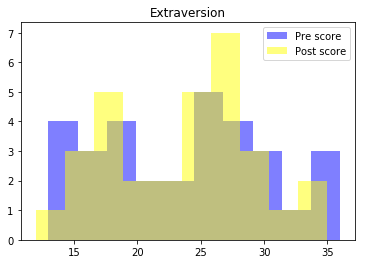

Agreeableness 0.9232558341581616


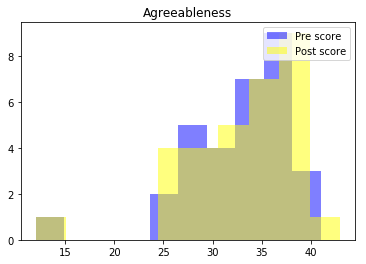

Conscientiousness 0.9469050526962443


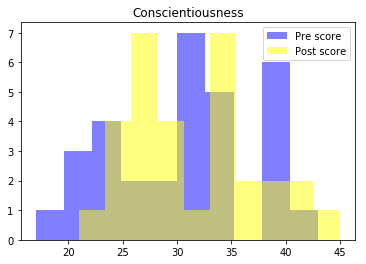

Neuroticism 0.8757596579586336


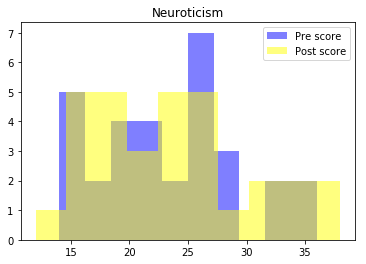

Openness 0.8712335534428887


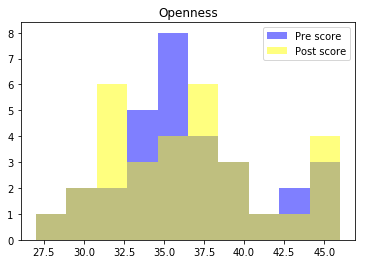

31


In [108]:
for dim in big5:
    pre_post_big5,score  = cal_corr(pre_df,post_df,dim)
    pre_post_big5.to_csv('big5_%s.csv'%(dim),index = False)
    print(dim,score[1,0])
    plt.hist(x=pre_post_big5[dim+'_x'], facecolor='blue', alpha=0.5, label='Pre score')
    plt.hist(x=pre_post_big5[dim+'_y'], facecolor='yellow', alpha=0.5, label='Post score')
    plt.title(dim)
    plt.legend(loc='upper right')
    plt.show()
print(len(pre_post_big5))

In [13]:
dim = 'Neuroticism'
pre_post_big5_ne,score  = cal_corr(pre_df,post_df,dim)
dim = 'Conscientiousness'
pre_post_big5_co,score  = cal_corr(pre_df,post_df,dim)


In [14]:
tmp = pd.merge(pre_post_big5_ne,pre_post_big5_co,on=['uid'],how='outer').dropna()
tmp['diff_ne'] = abs(tmp['Neuroticism_y']- tmp['Neuroticism_x'])
tmp['diff_co'] = abs(tmp['Conscientiousness_x']- tmp['Conscientiousness_y'])
tmp_ = tmp[['diff_ne','diff_co']]
tmp_.describe()
# plt.hist(x=pre_post_big5[dim+'_x'], facecolor='blue', alpha=0.5, label=dim+'pre_score')
#     plt.hist(x=pre_post_big5[dim+'_y'], facecolor='yellow', alpha=0.5, label=dim+'post_score')
#     plt.legend(loc='upper right')
#     plt.show()

,diff_ne,diff_co
count,31.000000,31.000000
mean,2.548387,1.838710
std,2.079082,1.439833
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,9.000000,5.000000


In [33]:
pre_post_big5.head()

,uid,type_x,Openness_x,type_y,Openness_y
0,u00,pre,45.0,post,46.0
1,u01,pre,39.0,post,37.0
2,u02,pre,32.0,post,30.0
3,u03,pre,27.0,post,27.0
4,u04,pre,29.0,post,31.0


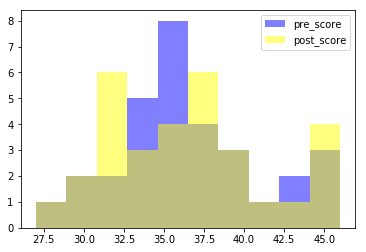

In [18]:
plt.hist(x=pre_post_big5.Openness_x, facecolor='blue', alpha=0.5, label='pre_score')
plt.hist(x=pre_post_big5.Openness_y, facecolor='yellow', alpha=0.5, label='post_score')
plt.legend(loc='upper right')
plt.show()

In [105]:
flourish = pd.read_csv('../dataset/survey/FlourishingScale.csv')
flourish_mod = flourish.dropna()
flourish_col = flourish_mod.columns
flourish_mod = flourish_mod.rename({flourish_col[i]:'Q'+str(i-1) for i in range(2,len(flourish_col))},axis='columns' )
for index,user in flourish_mod.iterrows():
    flourish_mod.at[index,'Overall'] = sum([int(user['Q'+str(col)]) for col in range(1,9)])
#     big5_mod_reverse.at[index,'Extraversion'] = sum([int(user['Q'+col]) for col in big5['Extraversion']])
flourish_mod = convert2int(flourish_mod)

In [106]:
flourish_mod.head()

,uid,type,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Overall
1,u01,pre,4,6,6,6,7,6,4,6,45
2,u02,pre,6,7,5,6,5,6,4,7,46
3,u03,pre,6,2,2,4,5,6,5,4,34
4,u04,pre,3,5,4,3,2,2,3,5,27
5,u05,pre,6,6,6,6,6,6,6,6,48


In [28]:
pre_flourish = flourish_mod[flourish_mod['type']=='pre']
post_flourish = flourish_mod[flourish_mod['type']=='post']
dim = 'Overall'
pre_post_flourish , score_f = cal_corr(pre_flourish,post_flourish,dim)
print(len(pre_flourish),len(post_flourish))
print(dim,score_f[1,0])
print(len(pre_post_flourish))

42 37
Overall 0.5439126076837955
34


In [32]:
pre_post_flourish.head()

,uid,type_x,Overall_x,type_y,Overall_y
0,u01,pre,45.0,post,46.0
1,u02,pre,46.0,post,44.0
2,u03,pre,34.0,post,31.0
3,u04,pre,27.0,post,33.0
4,u05,pre,48.0,post,50.0


In [107]:
flourish_mod.to_csv('flourish_cleaned.csv',index = False)
pre_post_flourish.to_csv('flourish_Overall.csv',index = False)

In [23]:
tmp_flourish = pre_post_flourish
tmp_flourish['diff_f'] = abs(pre_post_flourish['Overall_x']- pre_post_flourish['Overall_y'])

tmp_flourish['diff_f'].describe()

count    34.000000
mean      4.529412
std       6.880959
min       0.000000
25%       1.000000
50%       2.000000
75%       4.750000
max      29.000000
Name: diff_f, dtype: float64

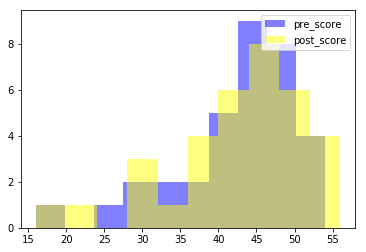

In [24]:
plt.hist(x=pre_post_flourish.Overall_x, facecolor='blue', alpha=0.5, label='pre_score')
plt.hist(x=pre_post_flourish.Overall_y, facecolor='yellow', alpha=0.5, label='post_score')
plt.legend(loc='upper right')
plt.show()

In [30]:
lonely = pd.read_csv('../dataset/survey/LonelinessScale.csv')


In [31]:
lonely.head()

,uid,type,1. I feel in tune with the people around me,2. I lack companionship,3. There is no one I can turn to,4. I do not feel alone,5. I feel part of a group of friends,6. I have a lot in common with the people around me,7. I am no longer close to anyone,8. My interests and ideas are not shared by those around me,...,11. I feel left out,12. My social relationships are superficial,13. No one really knows me well,14. I feel isolated from others,15. I can find companionship when I want it,16. There are people who really understand me,17. I am unhappy being so withdrawn,18. People are around me but not with me,19. There are people I can talk to,20. There are people I can turn to
0,u00,pre,Sometimes,Rarely,Never,Never,Often,Sometimes,Never,Never,...,Rarely,Rarely,Never,Never,Often,Rarely,Often,Sometimes,Often,Often
1,u01,pre,Sometimes,Rarely,Rarely,Sometimes,Often,Often,Never,Never,...,Rarely,Rarely,Never,Rarely,Often,Often,Sometimes,Never,Often,Often
2,u02,pre,Sometimes,Rarely,Rarely,Often,Often,Often,Never,Often,...,Rarely,Never,Never,Never,Often,Often,Never,Never,Often,Often
3,u03,pre,Sometimes,Rarely,Never,Often,Rarely,Rarely,Sometimes,Sometimes,...,Rarely,Rarely,Sometimes,Sometimes,Sometimes,Often,Sometimes,Sometimes,Sometimes,Sometimes
4,u04,pre,Sometimes,Sometimes,Sometimes,Sometimes,Rarely,Sometimes,Never,Rarely,...,Sometimes,Sometimes,Sometimes,Sometimes,Rarely,Rarely,Sometimes,Sometimes,Rarely,Rarely


In [40]:
print('before dropna',len(lonely))
lonely_mod = lonely.dropna()
lonely_mod = lonely_mod.replace('Never',1)
lonely_mod = lonely_mod.replace('Rarely',2)
lonely_mod = lonely_mod.replace('Sometimes',3)
lonely_mod = lonely_mod.replace('Often',4)

print('after dropna',len(lonely))
lonely_col = lonely_mod.columns
lonely_mod = lonely_mod.rename({lonely_col[i]:'Q'+str(i-1) for i in range(2,len(lonely_col))},axis='columns' )
#     big5_mod_reverse.at[index,'Extraversion'] = sum([int(user['Q'+col]) for col in big5['Extraversion']])
lonely_mod = convert2int(lonely_mod)



before dropna 83
after dropna 83


In [44]:
lonely_mod_reverse = lonely_mod.copy()
reverse = [1, 5, 6, 9, 10, 15, 16, 19, 20]
swap = {1:4,2:3,3:2,4:1}
for i in reverse:
    lonely_mod_reverse['Q'+str(i)] = [swap[score] for score in lonely_mod_reverse['Q'+str(i)]]
    lonely_mod_reverse = lonely_mod_reverse.rename({'Q'+str(i):'Q'+str(i)+'R'},axis='columns')

In [47]:
for index,user in lonely_mod.iterrows():
    lonely_mod_reverse.at[index,'Overall'] = sum([int(user['Q'+str(col)]) for col in range(1,21)])


In [50]:
len(lonely_mod_reverse[lonely_mod_reverse['Overall']<44])

0

In [110]:
lonely_mod_reverse.head()

,uid,type,Q1R,Q2,Q3,Q4,Q5R,Q6R,Q7,Q8,...,Q12,Q13,Q14,Q15R,Q16R,Q17,Q18,Q19R,Q20R,Overall
0,u00,pre,2,2,1,1,1,2,1,1,...,2,1,1,1,3,4,3,1,1,51
1,u01,pre,2,2,2,3,1,1,1,1,...,2,1,2,1,1,3,1,1,1,54
2,u02,pre,2,2,2,4,1,1,1,4,...,1,1,1,1,1,1,1,1,1,53
3,u03,pre,2,2,1,4,3,3,3,3,...,2,3,3,2,1,3,3,2,2,53
4,u04,pre,2,3,3,3,3,2,1,2,...,3,3,3,3,3,3,3,3,3,51


In [57]:
lonely_mod_reverse.sort_values('Overall').head()

,uid,type,Q1R,Q2,Q3,Q4,Q5R,Q6R,Q7,Q8,...,Q12,Q13,Q14,Q15R,Q16R,Q17,Q18,Q19R,Q20R,Overall
65,u31,post,2,1,2,4,1,2,1,2,...,3,1,1,4,3,1,2,3,3,44
81,u58,post,1,1,1,1,2,4,2,3,...,2,4,2,2,1,1,2,2,2,45
49,u03,post,3,1,1,3,4,3,4,3,...,2,3,2,2,1,2,2,2,3,45
12,u14,pre,2,1,1,4,1,2,1,1,...,1,1,1,3,1,1,1,1,1,46
53,u10,post,3,2,2,2,3,4,4,4,...,4,4,4,2,4,1,4,3,3,47


In [111]:
lonely_mod_reverse.to_csv('lonely_cleaned.csv',index = False)

In [59]:
pre_lonely = lonely_mod[lonely_mod['type']=='pre']
post_lonely = lonely_mod[lonely_mod['type']=='post']
dim = 'Overall'
pre_post_lonely , score_f = cal_corr(pre_lonely,post_lonely,dim)
print(len(pre_lonely),len(post_lonely))
print(dim,score_f[1,0])
print(len(pre_post_lonely))

46 37
Overall 0.5749246373197406
37


In [112]:
pre_post_lonely.to_csv('lonely_overall.csv',index = False)

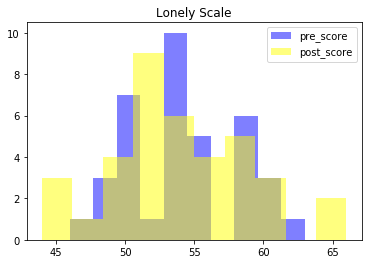

In [61]:
plt.hist(x=pre_post_lonely.Overall_x, facecolor='blue', alpha=0.5, label='pre_score')
plt.hist(x=pre_post_lonely.Overall_y, facecolor='yellow', alpha=0.5, label='post_score')
plt.legend(loc='upper right')
plt.title('Lonely Scale')
plt.show()

In [62]:
panas = pd.read_csv('../dataset/survey/panas.csv')

In [64]:
len(panas.columns)

20

In [66]:
panas.head()

,uid,type,Interested,Distressed,Upset,Strong,Guilty,Scared,Hostile,Enthusiastic,Proud,Irritable,Alert,Inspired,Nervous,Determined,Attentive,Jittery,Active,Afraid
0,u00,pre,5,4,3,4,3.0,5,5,3,3,3,4,4.0,NaN,4,3.0,2.0,2,5
1,u01,pre,4,2,2,2,5.0,1,1,3,3,2,4,3.0,3.0,4,3.0,2.0,4,1
2,u02,pre,4,1,1,2,2.0,2,1,3,2,2,3,2.0,2.0,2,3.0,3.0,2,1
3,u03,pre,4,2,2,4,5.0,5,5,3,1,1,5,3.0,1.0,3,3.0,5.0,4,1
4,u04,pre,4,2,1,3,3.0,1,1,3,3,2,3,1.0,2.0,3,3.0,1.0,4,1


In [74]:
list(range(2,len(panas_col)))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [75]:
len(panas_col)

20

In [85]:
print('before dropna',len(panas))
panas_mod = panas.dropna()
print('after dropna',len(panas_mod))
panas_col = panas_mod.columns
id_list =  list(range(1,len(panas_col)+1))
id_list .remove(3)
id_list .remove(13)
print(len(id_list),id_list)
panas_mod = panas_mod.rename({panas_col[i]:'Q'+str(id_list[i-2]) for i in range(2,len(panas_col))},axis='columns' )
#     big5_mod_reverse.at[index,'Extraversion'] = sum([int(user['Q'+col]) for col in big5['Extraversion']])
panas_mod = convert2int(panas_mod)
panas_mod.head()

before dropna 85
after dropna 81
18 [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]


,uid,type,Q1,Q2,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q14,Q15,Q16,Q17,Q18,Q19,Q20
1,u01,pre,4,2,2,2,5,1,1,3,3,2,4,3,3,4,3,2,4,1
2,u02,pre,4,1,1,2,2,2,1,3,2,2,3,2,2,2,3,3,2,1
3,u03,pre,4,2,2,4,5,5,5,3,1,1,5,3,1,3,3,5,4,1
4,u04,pre,4,2,1,3,3,1,1,3,3,2,3,1,2,3,3,1,4,1
5,u05,pre,4,2,1,4,5,5,5,4,2,2,4,3,1,3,4,1,4,5


In [115]:
panas_dim = {'Positive':[ 1,  5, 9, 10, 12, 14, 16, 17, 19], # 3
       'Negative': [ 2, 4, 6, 7, 8, 11, 15, 18, 20]} # 13
for index,user in panas_mod.iterrows():
    panas_mod.at[index,'Positive'] = sum([int(user['Q'+str(col)]) for col in panas_dim['Positive']])
    panas_mod.at[index,'Negative'] = sum([int(user['Q'+str(col)]) for col in panas_dim['Negative']])
panas_mod = convert2int(panas_mod)

In [116]:
panas_mod.head()

,uid,type,Q1,Q2,Q4,Q5,Q6,Q7,Q8,Q9,...,Q12,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Positive,Negative
1,u01,pre,4,2,2,2,5,1,1,3,...,4,3,3,4,3,2,4,1,30,19
2,u02,pre,4,1,1,2,2,2,1,3,...,3,2,2,2,3,3,2,1,23,15
3,u03,pre,4,2,2,4,5,5,5,3,...,5,3,1,3,3,5,4,1,30,27
4,u04,pre,4,2,1,3,3,1,1,3,...,3,1,2,3,3,1,4,1,27,14
5,u05,pre,4,2,1,4,5,5,5,4,...,4,3,1,3,4,1,4,5,32,27


In [113]:
panas_mod.to_csv('panas_overall.csv',index = False)

In [117]:
pre_df = panas_mod[panas_mod['type']=='pre']

post_df = panas_mod[panas_mod['type']=='post']
len(pre_df),len(post_df)

(43, 38)

dim: Positive
Positive 0.47974126890115576


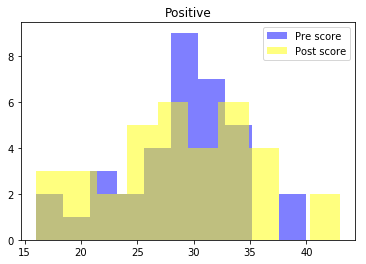

dim: Negative
Negative 0.18688026972513994


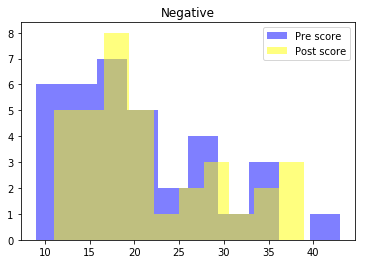

31


In [118]:
for dim in panas_dim:
    pre_post_panas,score  = cal_corr(pre_df,post_df,dim)
    print('dim:',dim)
    pre_post_panas.to_csv('panas_%s.csv'%(dim),index = False)
    print(dim,score[1,0])
    plt.hist(x=pre_post_panas[dim+'_x'], facecolor='blue', alpha=0.5, label='Pre score')
    plt.hist(x=pre_post_panas[dim+'_y'], facecolor='yellow', alpha=0.5, label='Post score')
    plt.title(dim)
    plt.legend(loc='upper right')
    plt.show()
print(len(pre_post_big5))